# ARC 2018 Depletion Model

In [ ]:
import openmc
import openmc.deplete
import openmc.data as data
import neutronics_material_maker as nmm
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro
from numpy.polynomial.polynomial import Polynomial

### Input Parameters

Below are all of the inputs needed to run the depletion scan simulation:

In [ ]:
main_folder_path = "/home/jlball/arc-proliferation/arc2018/"
xs_data_path = "/home/jlball/xs_data/endfb80_hdf5/cross_sections.xml"
chain_file = "simplified_chain_fast_spectrum.xml"
dopant_species = "Th"
Li6_enrichment = 7.8
percents_fertile = [0.01, 0.25, 1, 2.5, 5]
particles_per_batch = 500

## Materials ##

All material management is done using `neutronics_material_maker`. The name of each material must correspond to the name of the region of the DAGMC model to which it should be assigned.

In [ ]:
# Import and read JSON file containing volume information computed by paramak
file = open(main_folder_path + 'arc2018_volumes.json',)
volumes = json.load(file)
file.close()

In [ ]:
nmm.AddMaterialFromFile(main_folder_path + "mat_lib.json")
blanket_material_ids = np.empty(4)

def generate_materials(percent_fertile=0, Li6_enrichment=7.8, dopant_species='U'):
    plasma = nmm.Material.from_library("plasma").openmc_material

    flibe = nmm.Material.from_library("flibe", enrichment=Li6_enrichment)

    ib_mult = nmm.Material.from_library("beryllium").openmc_material
    ib_mult.name = 'inboard_multiplier'

    ob_mult = nmm.Material.from_library("beryllium").openmc_material
    ob_mult.name = 'outboard_multiplier'

    ob_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
    ob_outer_vv.name = 'outboard_outer_vv'

    ib_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
    ib_outer_vv.name = 'inboard_outer_vv'

    vv = nmm.Material.from_library("tungsten").openmc_material
    vv.name = "vv"

    if dopant_species == "U":
        dopant = nmm.Material.from_library("uf4")
    elif dopant_species == "Th":
        dopant = nmm.Material.from_library("thf4")
    else:
        print("Error: Invalid dopant type specified")
        return

    #Creating materials for all four FLiBe regions by mixing UF4 and FLiBe materials by volume
    ib_tank = nmm.Material.from_mixture(name='inboard_tank', materials=[flibe, dopant], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material
    ob_tank = nmm.Material.from_mixture(name='outboard_tank', materials=[flibe, dopant], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material

    ib_cc = nmm.Material.from_mixture(name='inboard_cc', materials=[flibe, dopant], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material
    ob_cc = nmm.Material.from_mixture(name='outboard_cc', materials=[flibe, dopant], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material

    ib_tank.volume = volumes['inboard_tank']
    ob_tank.volume = volumes['outboard_tank']
    ib_cc.volume = volumes['inboard_cc']
    ob_cc.volume = volumes['outboard_cc']

    materials = openmc.Materials(
        [
            plasma,
            ib_tank,
            ob_tank,
            ib_cc,
            ob_cc,
            ib_mult,
            ob_mult,
            ib_outer_vv,
            ob_outer_vv,
            vv
        ]
    )

    blanket_material_ids = np.array([ib_tank.id, ob_tank.id, ib_cc.id, ob_cc.id])
    print(blanket_material_ids)

    return materials, blanket_material_ids


Specify path to cross section file of desired library.

In [ ]:
#Provide path to cross section data
openmc.Materials.cross_sections = xs_data_path

## Geometry ##

The geometry is built in a separate file which uses the Paramak code to build a DAGMC model. Here it is imported and then a bounding region is provided.

In [ ]:
dag_univ = openmc.DAGMCUniverse(main_folder_path + "arc2018.h5m")

# creates an edge of universe boundary surface
vac_surf = openmc.Sphere(r=10000, surface_id=9999, boundary_type="vacuum")

# adds reflective surface for the sector model at 0 degrees
reflective_1 = openmc.Plane(
    a=math.sin(0),
    b=-math.cos(0),
    c=0.0,
    d=0.0,
    surface_id=9991,
    boundary_type="reflective",
)

# specifies the region as below the universe boundary and inside the reflective surfaces
region = -vac_surf & -reflective_1 

# creates a cell from the region and fills the cell with the dagmc geometry
containing_cell = openmc.Cell(cell_id=9999, region=region, fill=dag_univ)

geometry = openmc.Geometry(root=[containing_cell])

## Settings ##

A simple line source geometry is defined.

In [ ]:
# creates a simple isotropic neutron source in the center with 14MeV neutrons
source = openmc.Source()
# the distribution of radius is just a single value at the plasma major radius
radius = openmc.stats.Discrete([330.], [1])
# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([0], [1])
# the distribution of source azimuthal angles values is a uniform distribution between 0 and 0.5 Pi
# these angles must be the same as the reflective angles
angle = openmc.stats.Uniform(a=0., b=math.radians(180))
# this makes the ring source using the three distributions and a radius
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))
# sets the direction to isotropic
source.angle = openmc.stats.Isotropic()
# sets the energy distribution to a Muir distribution neutrons
source.energy = openmc.stats.Muir(e0=14080000.0, m_rat=5.0, kt=20000.0)

# specifies the simulation computational intensity
settings = openmc.Settings()
settings.batches = 10
settings.particles = particles_per_batch
settings.inactive = 0
settings.run_mode = "fixed source"
settings.source = source

## Tallies ##

Definition of tallies used.

In [ ]:
# Tritium Breeding Tally:
trit_tally = openmc.Tally(name='tbr')
#trit_tally.filters = [blanket_filter]
trit_tally.scores = ["(n,Xt)"]

# Tritium Breeding Tally:
Be_tally = openmc.Tally(name='Be')
#Be_tally.filters = [blanket_filter]
Be_tally.scores = ["(n,2n)"]

if dopant_species == "U":
    # Plutonium Breeding Tally:
    breed_tally = openmc.Tally(name='pbr')
    breed_tally.nuclides = ['U238']
    #plut_tally.filters = [blanket_filter]
    breed_tally.scores = ["absorption"]

elif dopant_species == "Th":
    # Uranium Breeding Tally:
    breed_tally = openmc.Tally(name='ubr')
    breed_tally.nuclides = ['Th232']
    #plut_tally.filters = [blanket_filter]
    breed_tally.scores = ["absorption"]

#Fission tally
fis_tally = openmc.Tally(name='fis')
#fis_tally.filters = [blanket_filter]
fis_tally.scores = ['fission']

tallies = openmc.Tallies([trit_tally, breed_tally, Be_tally, fis_tally])
tallies.export_to_xml()

## Depletion Run 

Setting up for the scan of depletion runs:

In [ ]:
# this tells openmc the decay paths between isotopes including proabilities of different routes and half lives
chain = openmc.deplete.Chain.from_xml(main_folder_path + chain_file)

# Set depletion calculation parameters:
number_of_steps = 5
total_time = 1 * 365 * 24 #hours
fusion_power = 525 # MW

energy_per_fusion = 2.8182e-18 # MJ (comes from converting 17.59 MeV to MJ)

time_steps = [total_time*60*60 / number_of_steps] * number_of_steps
source_rates = [fusion_power / energy_per_fusion] * number_of_steps

tbrs, tbrs_std = np.empty(len(percents_fertile)), np.empty(len(percents_fertile))

times_to_sq = np.empty(len(percents_fertile))
pu_purities = np.empty(len(percents_fertile))

Helper functions for extracting data during the depletion scan.

In [ ]:
# Only works for simulations with uniform timesteps
def compute_times():
    times = np.empty(number_of_steps + 1)
    for i in range(0, number_of_steps + 1):
        times[i] = i * time_steps[0] # seconds

    return times

def extract_tbr(return_arrays=False):
    num_time_steps = len(time_steps) + 1

    tbr_vals, tbr_std = np.empty(num_time_steps), np.empty(num_time_steps)
    for i in range(0, num_time_steps):
        sp = openmc.StatePoint(f'openmc_simulation_n{i}.h5')
        
        #Extract TBR values and std dev at each step in the simulation
        tbr_tally = sp.get_tally(name='tbr')
        tbr_vals[i] = tbr_tally.mean
        tbr_std[i] = tbr_tally.std_dev

    if return_arrays:
        return tbr_vals, tbr_std
    else:
        return np.mean(tbr_vals), np.mean(tbr_std)

#Converts number of atoms to kg of that isotope
def convert_to_kg(num_atoms, isotope):
    moles = num_atoms / Avogadro #divide by avogadro number to get in moles
    mass = (moles * data.atomic_mass(isotope))*0.001 #in kg (atmoic mass is molar mass in units of g/mol)
    return mass

def get_atoms(isotope, results):
    atoms = 0
    for mat in range(0, len(blanket_material_ids)):
        _, result = results.get_atoms(mat, isotope)
        atoms += result
    
    return atoms

#Retrieve the mass of a particular isotope in the blanket
def get_mass(isotope, results):
    atoms = get_atoms(isotope, results)
    mass = convert_to_kg(atoms, isotope)
    return mass

def extract_time_to_sq(times, results, dopant_species):
    if dopant_species == "U":
        masses = get_mass('Pu239', results)
    elif dopant_species == "Th":
        masses = get_mass('U233', results)

    fit = Polynomial.fit(times, masses, 1)
    fit_masses = fit(times)

    sig_quantity = 8 # kg, same for both U233 and Pu239
    time_to_sig_quantity = (fit - sig_quantity).roots()[0] 
    return time_to_sig_quantity

def extract_isotopic_purity(results):
    pu_isotopes = ['Pu238', 'Pu239', 'Pu240', 'Pu241']
    total_pu_atoms = 0
    for iso in pu_isotopes:
        atoms = get_atoms(iso, results)[-1]
        total_pu_atoms += atoms

    atoms_239 = get_atoms('Pu239', results)[-1] 
    return atoms_239/total_pu_atoms

Performing the scan:

In [ ]:
for i, percent_fertile in enumerate(percents_fertile):
    # Create materials object with desired pertile percent:
    materials, blanket_material_ids = generate_materials(percent_fertile=percent_fertile, Li6_enrichment=Li6_enrichment, dopant_species=dopant_species)

    #Create OpenMC model object using this new materials object:
    model = openmc.Model(
        materials=materials, geometry=geometry, settings=settings, tallies=tallies
    )

    # Create transport operator using the above OpenMC model
    operator = openmc.deplete.Operator(model, main_folder_path + chain_file, normalization_mode='source-rate')

    # Create integrator which will perform the calculation using a particular algorhithm
    integrator = openmc.deplete.PredictorIntegrator(
        operator=operator, timesteps=time_steps, source_rates=source_rates, 
    )

    print("###### BEGIN DEPLETION CALCULATION FOR", percent_fertile, "PERCENT FERTILE BLANKET ######")
    integrator.integrate()

    print("###### EXTRACT RESULTS ######")
    tbr, tbr_std = extract_tbr()
    tbrs[i] = tbr
    tbrs_std[i] = tbr_std

    #Extract time to significant quantity:
    results = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")
    times = compute_times()

    times_to_sq[i] = extract_time_to_sq(times, results, dopant_species)
    pu_purities[i] = extract_isotopic_purity(results)

collected_data = np.array([percents_fertile, times_to_sq, tbrs, tbrs_std])
np.save(dopant_species + "_data", collected_data)


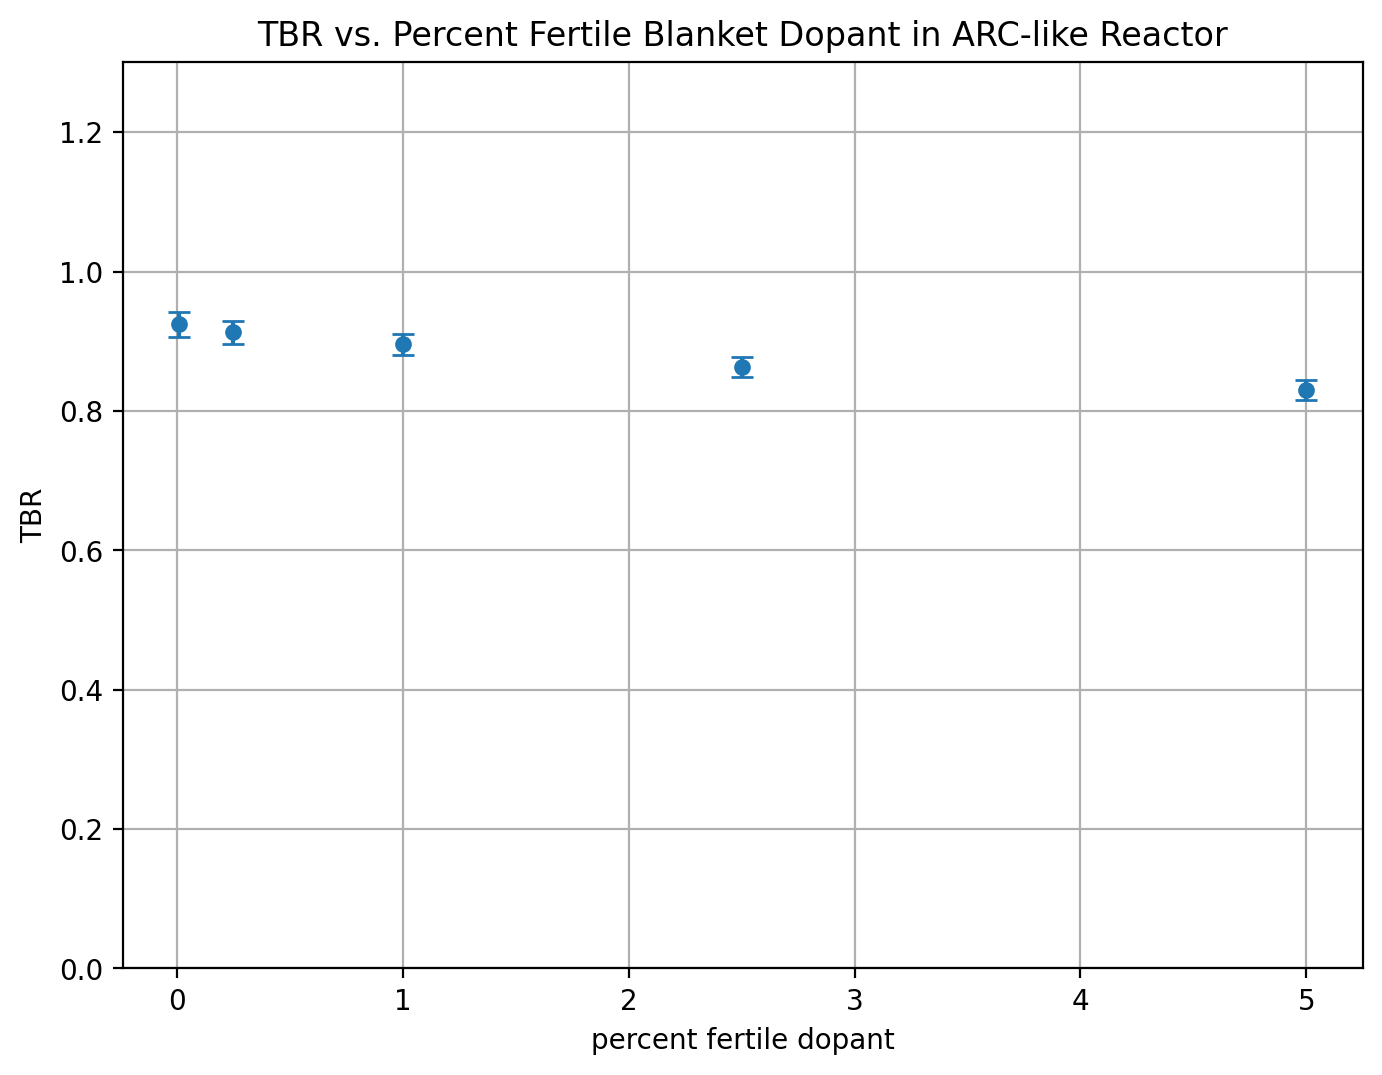

In [12]:
plot_dpi = 200
fig, ax = plt.subplots(dpi=plot_dpi)
ax.errorbar(percents_fertile, tbrs, yerr=tbrs_std, fmt='.', ms=10, capsize=4)

ax.set(title='TBR vs. Percent Fertile Blanket Dopant in ARC-like Reactor', xlabel="percent fertile dopant", ylabel='TBR', ylim=[0, 1.3])
ax.grid()

plt.gcf().set_size_inches(8, 6)
plt.show()

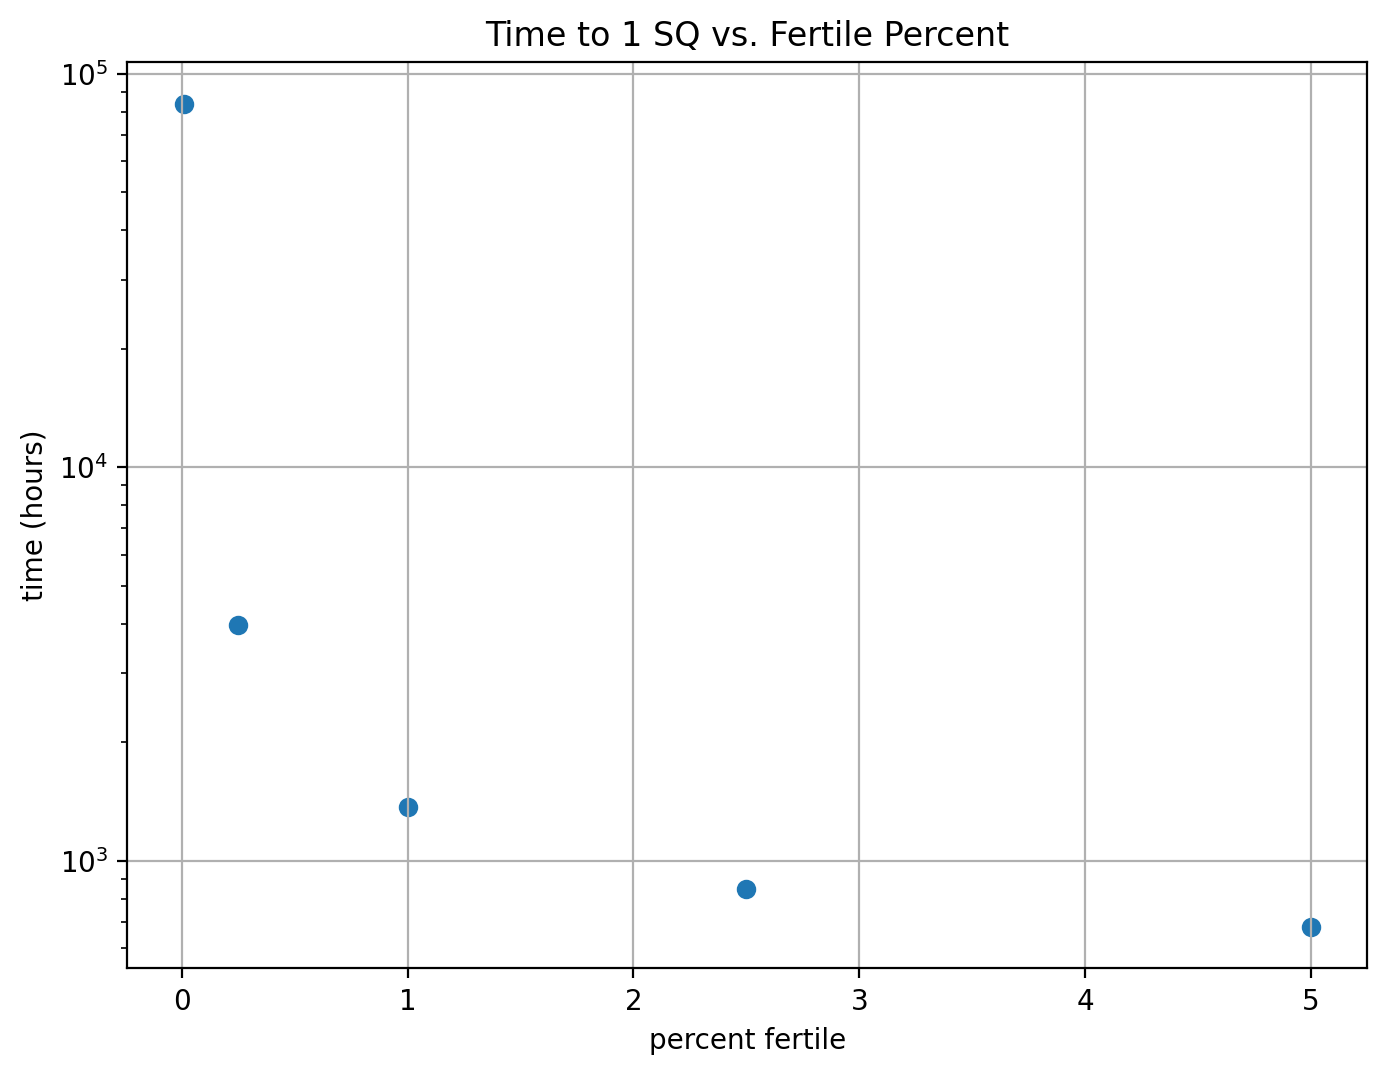

In [13]:
fig, ax = plt.subplots(dpi=plot_dpi)

ax.scatter(percents_fertile, times_to_sq/(60*60))

ax.set(title="Time to 1 SQ vs. Fertile Percent", xlabel="percent fertile", ylabel='time (hours)')
ax.grid()
ax.set_yscale('log')

plt.gcf().set_size_inches(8, 6)
plt.show()

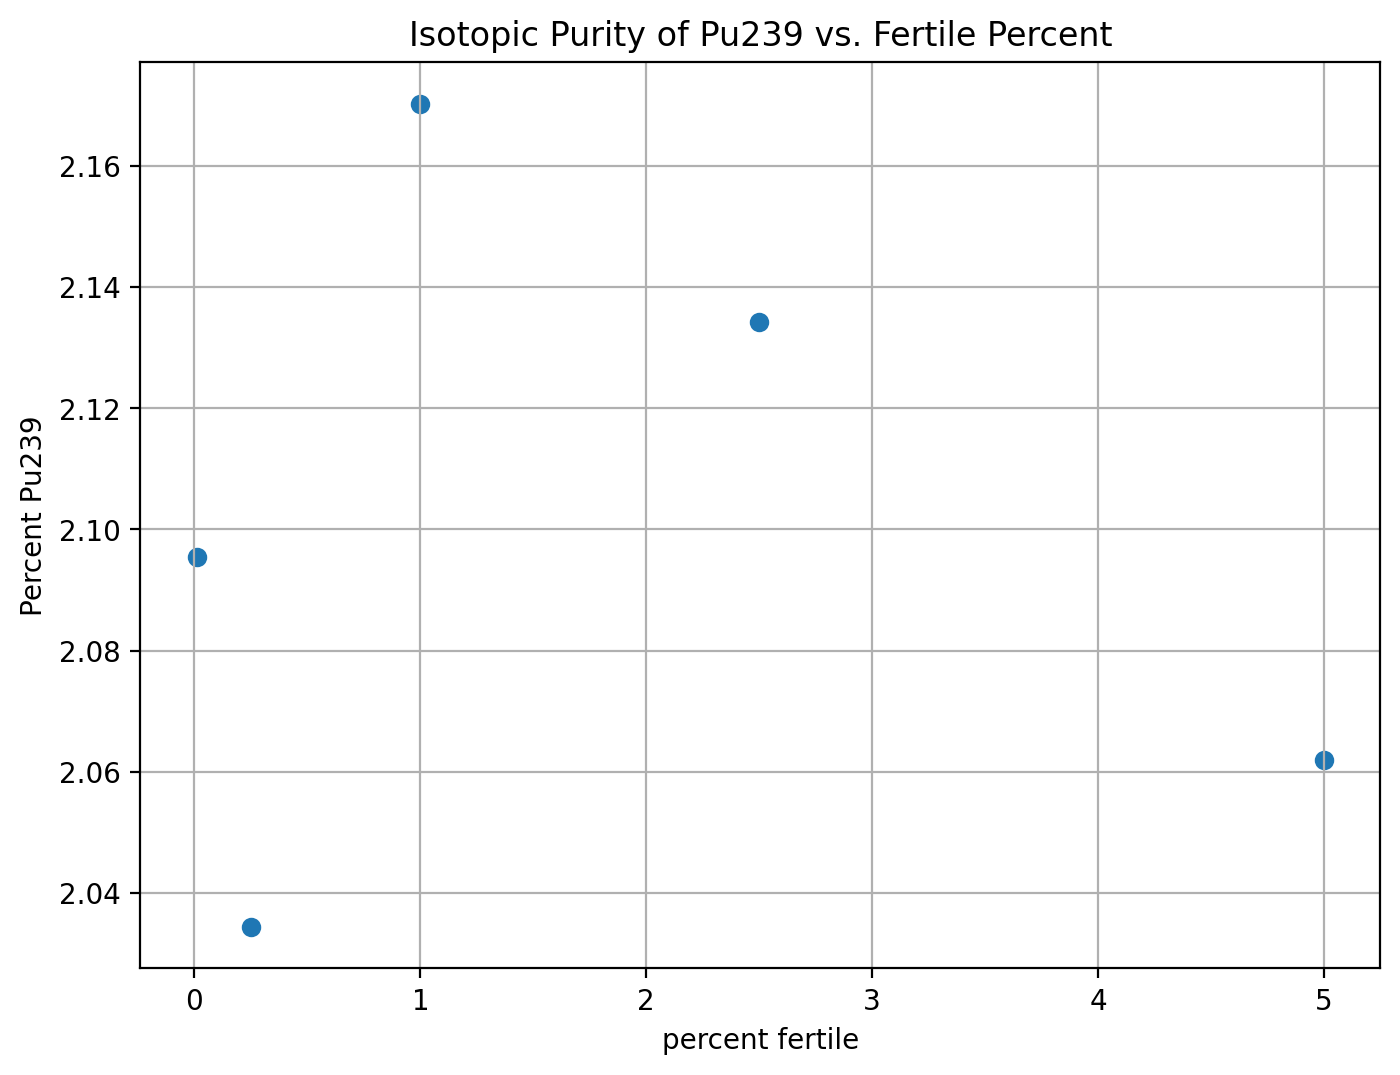

In [14]:
fig, ax = plt.subplots(dpi=plot_dpi)

ax.scatter(percents_fertile, pu_purities*100)

ax.set(title="Isotopic Purity of Pu239 vs. Fertile Percent", xlabel="percent fertile", ylabel='Percent Pu239')
ax.grid()

plt.gcf().set_size_inches(8, 6)
plt.show()